In [1]:
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util

In [2]:
ds_djf_regional = xr.open_zarr('data/cesm-le-fields-djf-regional-timeseries.zarr')

## compute retrospective trends 

In [3]:
%%time
# set up trend dimensions
trend_year = xr.DataArray(np.arange(1925, 2101, 1), dims=('time'))
trend_length = xr.DataArray([5, 10, 20, 60], dims=('trend_length'))

# loop over trends
ds_list = []
for end_year, n_year in product(trend_year.values, trend_length.values):

    # subset data for the time-period of this trend
    ds = ds_djf_regional.sel(time=slice(end_year-n_year+1, end_year))
    if len(ds.time) != n_year: 
        continue
        
    # loop over vars and compute trends
    da_list = []
    for v in ds.data_vars:
        da = util.linear_trend(
            ds[v]
        ).expand_dims(
            trend_length=[n_year], 
            trend_year=[end_year]
        ) * 10.
        da.attrs = ds[v].attrs
        da.attrs['units'] = ds[v].units + ' decade$^{-1}$'
        da_list.append(da)
        
    ds_list.append(xr.merge(da_list))
    
ds_djf_rgn_trnd = xr.combine_by_coords(ds_list).compute()
ds_djf_rgn_trnd

CPU times: user 41.9 s, sys: 2.8 s, total: 44.7 s
Wall time: 42.2 s


<xarray.Dataset>
Dimensions:       (length: 3, member_id: 34, region: 2, trend_length: 4, trend_year: 176)
Coordinates:
  * length        (length) float64 20.0 40.0 60.0
  * member_id     (member_id) int64 1 2 9 10 11 12 13 ... 35 101 102 103 104 105
  * trend_length  (trend_length) int64 5 10 20 60
  * region        (region) <U17 'Southern Ocean' 'Atlantic Quadrant'
  * trend_year    (trend_year) int64 1925 1926 1927 1928 ... 2097 2098 2099 2100
Data variables:
    Chl_surf      (trend_length, trend_year, member_id, region) float64 0.01585 ... -0.00122
    IFRAC         (trend_length, trend_year, member_id, region) float64 0.001716 ... -0.002642
    KGP           (trend_length, trend_year, length, member_id, region) float64 -0.001916 ... -0.000133
    SST           (trend_length, trend_year, member_id, region) float64 0.188 ... 0.0848

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


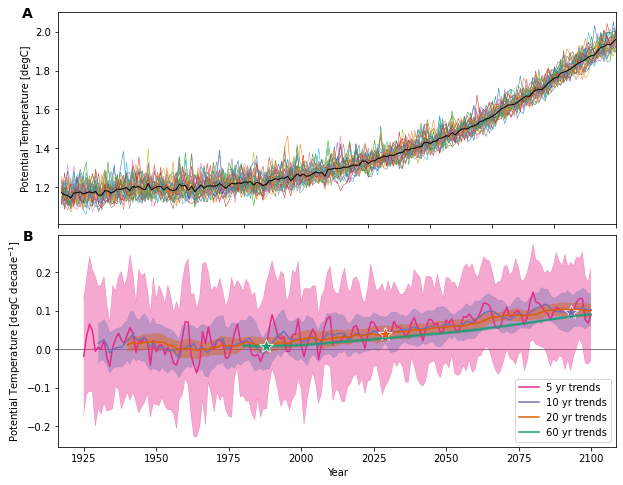

In [4]:
v = 'SST'
region = 'Southern Ocean'

hexcolor = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylabel('O$_2$ [mmol m$^{-3}$]')

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ax.plot(ds_djf_regional.time, var_i, '-', linewidth=0.5)
    
ax.plot(ds_djf_regional.time, ds_djf_regional[v].sel(region=region).mean('member_id'), '-', 
        linewidth=1, color='k')

ax.set_xticklabels([])
ax.set_ylabel(f'{ds_djf_regional[v].long_name} [{ds_djf_regional[v].units}]')

ax = fig.add_subplot(gs[1, 0])
handles = []
for n_year in ds_djf_rgn_trnd.trend_length.values:
    da = ds_djf_rgn_trnd[v].sel(trend_length=n_year, region=region)
    
    y_mean = da.mean('member_id')
    y_std = da.std('member_id')
    
    y_low = y_mean - y_std
    y_hi = y_mean + y_std
    
    color = hexcolor.pop()
    
    p = ax.plot(
        ds_djf_rgn_trnd.trend_year, y_mean, 
        '-', label=f'{n_year:d} yr trends', color=color
    )
    handles.append(p[0])
    
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_low,
        '-', label='%d yr trends', color=color,
        linewidth=0.2
    )            
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_hi, 
        '-', label='%d yr trends', color=color, 
        linewidth=0.2
    )
    
    ax.fill_between(
        ds_djf_rgn_trnd.trend_year, y_low, y_hi,
        facecolor=color, alpha=0.4
    )
    

    s2n = y_mean / y_std
    for l in range(len(ds_djf_rgn_trnd.trend_year)):
        
        # where the signal to noise is greater than 2, detect!
        if all(np.abs(s2n[l:]) > 2):
            toex = ds_djf_rgn_trnd.trend_year.values[l]
            toey = y_mean.values[l]
            ax.plot(toex, toey, '*', 
                    color=color, 
                    markeredgecolor='w',
                    markeredgewidth=.8,
                    markersize=15)
            break
            
ax.legend(handles, [h.get_label() for h in handles])
ax.axhline(0, color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel('Year')
ax.set_ylabel(f'{ds_djf_rgn_trnd[v].long_name} [{ds_djf_rgn_trnd[v].units}]')

gs.update(hspace=0.05)

ax = fig.get_axes()
alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1 - 0.01
    x = p.x0 - 0.05
    fig.text(x, y, '%s'%alp[i],
             fontsize=14.,
             fontweight='semibold')
plt.savefig('figures/SST-timeseries-trends-TOE-SO.png')

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'KGP' (trend_year: 176)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -3.53457508e-06,
       -6.82159070e-05, -1.01755607e-04, -7.39150454e-05, -6.96786403e-05,
       -9.36029767e-05, -1.17066950e-04, -1.46334150e-04, -1.25442800e-04,
       -1.35183105e-04, -1.53909896e-04, -1.47202933e-04, -1.82379167e-04,
       -1.84129635e-04, -1.66225206e-04, -1.40234589e-04, -8.28636957e-05,
       -4.40679025e-05,  1.71908899e-06,  2.69012680e-06,  2.78638480e-05,
        2.67468469e-05,  2.11093233e-05,  4.48521343e-05,  1.02584924e-04,
        1.01720618e-04,  8.60217693e-05,  8.02478817e-05,  1.09074032e-04,
        9.71795786e-05,  9.45301701e-05,  1.03032878e-04,  5.01614332e-05,
        4.48742298e-05,  6.14784301e-05,  2.90052659e-05,  3.25833183e-05,
        1.71947224e-05,  2.56916149e-07, -2.88094496e-05, -6.00071728e-05,
       -8.61281300e-05, -9.09859365e-05, -8.72316705e-05, -2.44284066e-05,
       -9.52169706e-06,  7.75848275e-07,  1.54019735e-05,  3.31285978e-05,
        3.48835495e-05,  3.04002500e-05,  7.29798001e-05,  9.04054906e-05,
        1.06760331e-04,  1.28551182e-04,  1.27963696e-04,  1.47301735e-04,
        1.08639938e-04,  8.35263575e-05,  6.56266112e-05,  5.22954747e-05,
        2.83721169e-05, -4.49596451e-06, -7.02246502e-06, -1.96323547e-05,
       -4.20370649e-05, -4.56565505e-05, -5.55007807e-05, -9.18088723e-05,
       -1.14840306e-04, -1.46907894e-04, -1.55869791e-04, -1.44687553e-04,
       -1.50714577e-04, -1.30799792e-04, -1.26344127e-04, -9.96283853e-05,
       -1.18205269e-04, -1.18250320e-04, -1.08127958e-04, -9.48362594e-05,
       -8.66266452e-05, -7.10265424e-05, -5.46910984e-05, -6.48143363e-05,
       -8.68186154e-05, -8.28617518e-05, -1.01931823e-04, -1.03105893e-04,
       -1.09996456e-04, -1.15007087e-04, -1.20306150e-04, -1.48644597e-04,
       -1.64097387e-04, -1.38177021e-04, -1.56403805e-04, -1.27150836e-04,
       -1.09567518e-04, -1.11452665e-04, -1.03741616e-04, -6.04038367e-05,
       -8.43285896e-05, -7.35117678e-05, -6.94820941e-05, -5.91782192e-05,
       -7.32050197e-05, -8.17433422e-05, -9.37942223e-05, -7.59971726e-05,
       -7.74875987e-05, -7.33261108e-05, -7.53417008e-05, -9.01732702e-05,
       -1.20072652e-04, -1.22974620e-04, -1.39210512e-04, -1.09806916e-04,
       -9.92550851e-05, -1.18093364e-04, -1.30560015e-04, -8.12697715e-05,
       -1.05663391e-04, -1.21532000e-04, -1.15811884e-04, -1.35042339e-04,
       -1.59119078e-04, -1.74710371e-04, -1.54369944e-04, -1.58168059e-04,
       -1.59911866e-04, -1.62646710e-04, -1.68485841e-04, -1.44696428e-04,
       -1.65845975e-04, -1.73474864e-04, -1.65380428e-04, -1.26645168e-04,
       -1.20901117e-04, -1.31818929e-04, -1.45358038e-04, -1.11013223e-04,
       -1.09505172e-04, -1.30943992e-04, -1.23508697e-04, -1.47353524e-04,
       -1.60408715e-04, -1.75711282e-04, -1.79236819e-04, -1.73799724e-04,
       -1.77508818e-04, -1.78390641e-04, -1.80033144e-04, -1.52054986e-04,
       -1.53381888e-04, -1.74368195e-04, -1.63431114e-04, -1.34637625e-04,
       -1.16727421e-04, -1.23335049e-04, -1.36020557e-04, -1.09685645e-04])
Coordinates:
    length        float64 40.0
    trend_length  int64 20
    region        <U17 'Southern Ocean'
  * trend_year    (trend_year) int64 1925 1926 1927 1928 ... 2097 2098 2099 2100

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


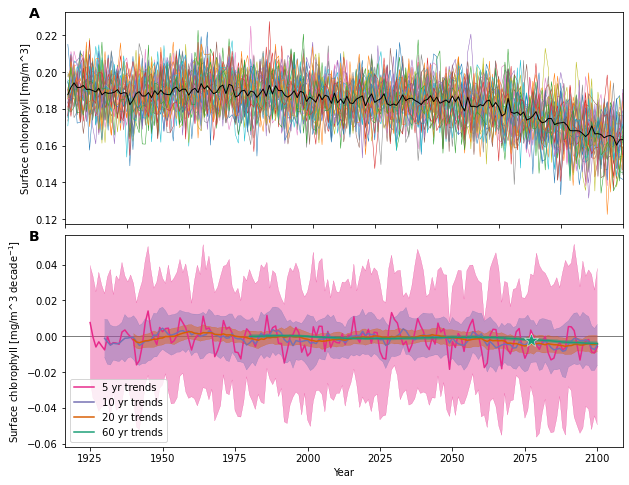

In [14]:
v = 'Chl_surf'
region = 'Southern Ocean'

hexcolor = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylabel('O$_2$ [mmol m$^{-3}$]')

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ax.plot(ds_djf_regional.time, var_i, '-', linewidth=0.5)
    
ax.plot(ds_djf_regional.time, ds_djf_regional[v].sel(region=region).mean('member_id'), '-', 
        linewidth=1, color='k')

ax.set_xticklabels([])
ax.set_ylabel(f'{ds_djf_regional[v].long_name} [{ds_djf_regional[v].units}]')

ax = fig.add_subplot(gs[1, 0])
handles = []
for n_year in ds_djf_rgn_trnd.trend_length.values:
    da = ds_djf_rgn_trnd[v].sel(trend_length=n_year, region=region)
    
    y_mean = da.mean('member_id')
    y_std = da.std('member_id')
    
    y_low = y_mean - y_std
    y_hi = y_mean + y_std
    
    color = hexcolor.pop()
    
    p = ax.plot(
        ds_djf_rgn_trnd.trend_year, y_mean, 
        '-', label=f'{n_year:d} yr trends', color=color
    )
    handles.append(p[0])
    
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_low,
        '-', label='%d yr trends', color=color,
        linewidth=0.2
    )            
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_hi, 
        '-', label='%d yr trends', color=color, 
        linewidth=0.2
    )
    
    ax.fill_between(
        ds_djf_rgn_trnd.trend_year, y_low, y_hi,
        facecolor=color, alpha=0.4
    )
    

    s2n = y_mean / y_std
    for l in range(len(ds_djf_rgn_trnd.trend_year)):
        
        # where the signal to noise is greater than 2, detect!
        if all(np.abs(s2n[l:]) > 2):
            toex = ds_djf_rgn_trnd.trend_year.values[l]
            toey = y_mean.values[l]
            ax.plot(toex, toey, '*', 
                    color=color, 
                    markeredgecolor='w',
                    markeredgewidth=0.5,
                    markersize=15)
            break
            
ax.legend(handles, [h.get_label() for h in handles])
ax.axhline(0, color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel('Year')
ax.set_ylabel(f'{ds_djf_rgn_trnd[v].long_name} [{ds_djf_rgn_trnd[v].units}]')

gs.update(hspace=0.05)

ax = fig.get_axes()
alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1 - 0.01
    x = p.x0 - 0.05
    fig.text(x, y, '%s'%alp[i],
             fontsize=14.,
             fontweight='semibold')
    
plt.savefig('figures/CHL-timeseries-trends-TOE-SO.png')

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


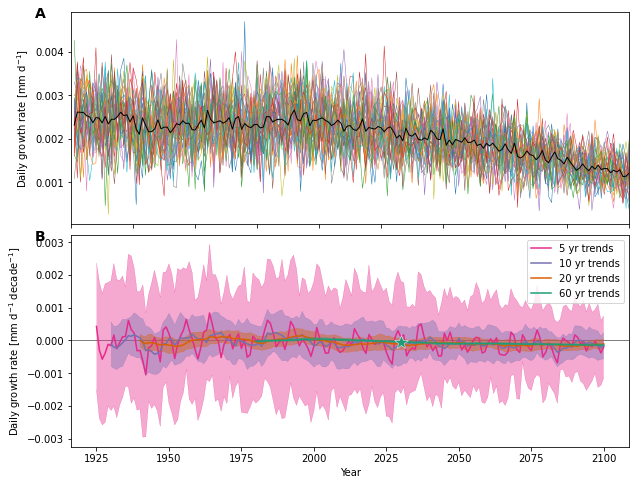

In [13]:
v = 'KGP'
region = 'Southern Ocean'

hexcolor = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylabel('O$_2$ [mmol m$^{-3}$]')

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length='40')
    ax.plot(ds_djf_regional.time, var_i, '-', linewidth=0.5)
    
ax.plot(ds_djf_regional.time, ds_djf_regional[v].sel(region=region).sel(length='40').mean('member_id'), '-', 
        linewidth=1, color='k')

ax.set_xticklabels([])
ax.set_ylabel(f'{ds_djf_regional[v].long_name} [{ds_djf_regional[v].units}]')

ax = fig.add_subplot(gs[1, 0])
handles = []
for n_year in ds_djf_rgn_trnd.trend_length.values:
    da = ds_djf_rgn_trnd[v].sel(trend_length=n_year, region=region, length='40')
    
    y_mean = da.mean('member_id')
    y_std = da.std('member_id')
    
    y_low = y_mean - y_std
    y_hi = y_mean + y_std
    
    color = hexcolor.pop()
    
    p = ax.plot(
        ds_djf_rgn_trnd.trend_year, y_mean, 
        '-', label=f'{n_year:d} yr trends', color=color
    )
    handles.append(p[0])
    
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_low,
        '-', label='%d yr trends', color=color,
        linewidth=0.2
    )            
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_hi, 
        '-', label='%d yr trends', color=color, 
        linewidth=0.2
    )
    
    ax.fill_between(
        ds_djf_rgn_trnd.trend_year, y_low, y_hi,
        facecolor=color, alpha=0.4
    )

    s2n = y_mean / y_std
    for l in range(len(ds_djf_rgn_trnd.trend_year)):
        
        # where the signal to noise is greater than 2, detect!
        if all(np.abs(s2n[l:]) > 2):
            toex = ds_djf_rgn_trnd.trend_year.values[l]
            toey = y_mean.values[l]
            ax.plot(toex, toey, '*', 
                    color=color, 
                    markeredgecolor='w',
                    markeredgewidth=.5,
                    markersize=15)
            break
            
ax.legend(handles, [h.get_label() for h in handles])
ax.axhline(0, color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel('Year')
ax.set_ylabel(f'{ds_djf_rgn_trnd[v].long_name} [{ds_djf_rgn_trnd[v].units}]')

gs.update(hspace=0.05)

ax = fig.get_axes()
alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1 - 0.01
    x = p.x0 - 0.05
    fig.text(x, y, '%s'%alp[i],
             fontsize=14.,
             fontweight='semibold')
    
plt.savefig('figures/KGP-timeseries-trends-TOE-SO.png')

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


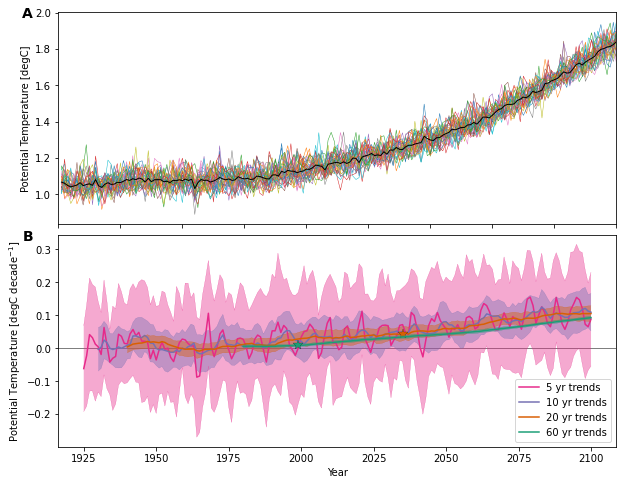

In [5]:
v = 'SST'
region = 'WAP & Atlantic'

hexcolor = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylabel('O$_2$ [mmol m$^{-3}$]')

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region)
    ax.plot(ds_djf_regional.time, var_i, '-', linewidth=0.5)
    
ax.plot(ds_djf_regional.time, ds_djf_regional[v].sel(region=region).mean('member_id'), '-', 
        linewidth=1, color='k')

ax.set_xticklabels([])
ax.set_ylabel(f'{ds_djf_regional[v].long_name} [{ds_djf_regional[v].units}]')

ax = fig.add_subplot(gs[1, 0])
handles = []
for n_year in ds_djf_rgn_trnd.trend_length.values:
    da = ds_djf_rgn_trnd[v].sel(trend_length=n_year, region=region)
    
    y_mean = da.mean('member_id')
    y_std = da.std('member_id')
    
    y_low = y_mean - y_std
    y_hi = y_mean + y_std
    
    color = hexcolor.pop()
    
    p = ax.plot(
        ds_djf_rgn_trnd.trend_year, y_mean, 
        '-', label=f'{n_year:d} yr trends', color=color
    )
    handles.append(p[0])
    
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_low,
        '-', label='%d yr trends', color=color,
        linewidth=0.2
    )            
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_hi, 
        '-', label='%d yr trends', color=color, 
        linewidth=0.2
    )
    
    ax.fill_between(
        ds_djf_rgn_trnd.trend_year, y_low, y_hi,
        facecolor=color, alpha=0.4
    )
    

    s2n = y_mean / y_std
    for l in range(len(ds_djf_rgn_trnd.trend_year)):
        
        # where the signal to noise is greater than 2, detect!
        if all(np.abs(s2n[l:]) > 2):
            toex = ds_djf_rgn_trnd.trend_year.values[l]
            toey = y_mean.values[l]
            ax.plot(toex, toey, '*', 
                    color=color, 
                    markeredgecolor='w',
                    markeredgewidth=0.5,
                    markersize=15)
            break
            
ax.legend(handles, [h.get_label() for h in handles])
ax.axhline(0, color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel('Year')
ax.set_ylabel(f'{ds_djf_rgn_trnd[v].long_name} [{ds_djf_rgn_trnd[v].units}]')

gs.update(hspace=0.05)

ax = fig.get_axes()
alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1 - 0.01
    x = p.x0 - 0.05
    fig.text(x, y, '%s'%alp[i],
             fontsize=14.,
             fontweight='semibold')

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


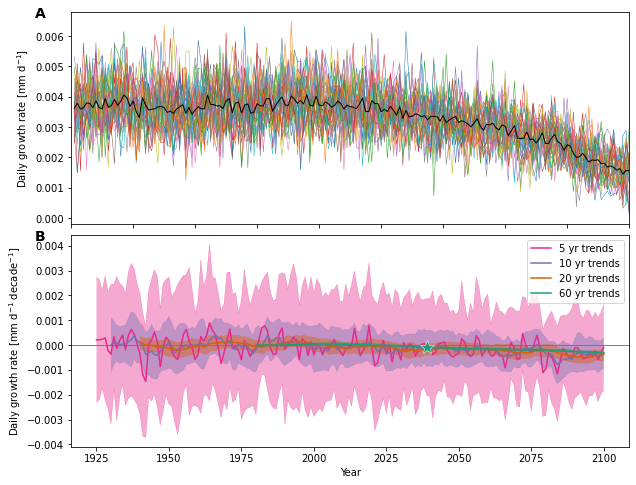

In [12]:
v = 'KGP'
region = 'WAP & Atlantic'

hexcolor = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
#ax.set_ylabel('O$_2$ [mmol m$^{-3}$]')

for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length='40')
    ax.plot(ds_djf_regional.time, var_i, '-', linewidth=0.5)
    
ax.plot(ds_djf_regional.time, ds_djf_regional[v].sel(region=region).sel(length='40').mean('member_id'), '-', 
        linewidth=1, color='k')

ax.set_xticklabels([])
ax.set_ylabel(f'{ds_djf_regional[v].long_name} [{ds_djf_regional[v].units}]')

ax = fig.add_subplot(gs[1, 0])
handles = []
for n_year in ds_djf_rgn_trnd.trend_length.values:
    da = ds_djf_rgn_trnd[v].sel(trend_length=n_year, region=region, length='40')
    
    y_mean = da.mean('member_id')
    y_std = da.std('member_id')
    
    y_low = y_mean - y_std
    y_hi = y_mean + y_std
    
    color = hexcolor.pop()
    
    p = ax.plot(
        ds_djf_rgn_trnd.trend_year, y_mean, 
        '-', label=f'{n_year:d} yr trends', color=color
    )
    handles.append(p[0])
    
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_low,
        '-', label='%d yr trends', color=color,
        linewidth=0.2
    )            
    ax.plot(
        ds_djf_rgn_trnd.trend_year, y_hi, 
        '-', label='%d yr trends', color=color, 
        linewidth=0.2
    )
    
    ax.fill_between(
        ds_djf_rgn_trnd.trend_year, y_low, y_hi,
        facecolor=color, alpha=0.4
    )

    s2n = y_mean / y_std
    for l in range(len(ds_djf_rgn_trnd.trend_year)):
        
        # where the signal to noise is greater than 2, detect!
        if all(np.abs(s2n[l:]) > 2):
            toex = ds_djf_rgn_trnd.trend_year.values[l]
            toey = y_mean.values[l]
            ax.plot(toex, toey, '*', 
                    color=color, 
                    markeredgecolor='w',
                    markeredgewidth=0.5,
                    markersize=15)
            break
            
ax.legend(handles, [h.get_label() for h in handles])
ax.axhline(0, color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel('Year')
ax.set_ylabel(f'{ds_djf_rgn_trnd[v].long_name} [{ds_djf_rgn_trnd[v].units}]')

gs.update(hspace=0.05)

ax = fig.get_axes()
alp = [chr(i).upper() for i in range(97,97+26)]
for i,axi in enumerate(ax):
    p = axi.get_position()
    y = p.y1 - 0.01
    x = p.x0 - 0.05
    fig.text(x, y, '%s'%alp[i],
             fontsize=14.,
             fontweight='semibold')
    
plt.savefig('figures/KGP-timeseries-trends-TOE-WAPAT.png')